## SETUP

In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

## PARAMETERS

In [48]:
image_size = 256
generator_input = int(image_size/8)
batch_size = 8

## IMPORT

In [49]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "images_proc/full_selection_sel", label_mode=None, image_size=(image_size, image_size), batch_size=batch_size, crop_to_aspect_ratio=True
)
dataset = dataset.map(lambda x: x / 255.0)

Found 2544 files belonging to 1 classes.


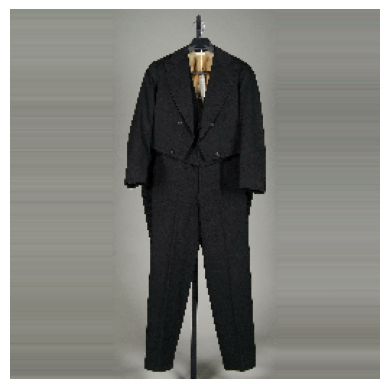

In [50]:
# display one image
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

## DISCRIMINATOR

In [51]:
cnn_base = VGG19(weights='imagenet', include_top=False, input_shape=(image_size,image_size,3))
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [52]:
# Freeze VGG19

cnn_base.trainable = True
set_trainable = False
for layer in cnn_base.layers[:-5]:
    layer.trainable = False

In [53]:
cnn_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [54]:
discriminator = keras.Sequential(
    [
        cnn_base,
        # keras.Input(shape=(image_size, image_size, 3)),
        # layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        # layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        # layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 24,218,945
Trainable params: 13,633,793
Non-trainable params: 10,585,152
_________________________________________________________________


In [55]:
for layer in discriminator.layers:
    print(layer.name, layer.trainable)

vgg19 True
flatten_2 True
dense_3 True
dropout_1 True
dense_4 True


## GENERATOR

In [56]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(generator_input * generator_input * 128),
        layers.Reshape((generator_input, generator_input, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 131072)            16908288  
                                                                 
 reshape_1 (Reshape)         (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 64, 64, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 128, 128, 256)    524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 128, 128, 256)     0 

## GAN

In [57]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

## GAN monitor

In [58]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("BasicGAN_gen/8/generated_img_%03d_%d.png" % (epoch, i))

## FIT

In [59]:
learning_rate = 0.0001

In [60]:
epochs = 20  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    g_optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)

Epoch 1/20
318/318 [==============================] - 108s 326ms/step - d_loss: -21.0041 - g_loss: 2567.5398
Epoch 2/20
318/318 [==============================] - 106s 331ms/step - d_loss: -37505.8242 - g_loss: 6592794.0000
Epoch 3/20
318/318 [==============================] - 106s 333ms/step - d_loss: 810.1566 - g_loss: 7290.1934
Epoch 4/20
318/318 [==============================] - 106s 332ms/step - d_loss: 164.9423 - g_loss: 6899.5581
Epoch 5/20
318/318 [==============================] - 106s 332ms/step - d_loss: 108.8176 - g_loss: 9602.0527
Epoch 6/20
318/318 [==============================] - 102s 320ms/step - d_loss: 106.7824 - g_loss: 11654.1436
Epoch 7/20
318/318 [==============================] - 106s 333ms/step - d_loss: 23.5774 - g_loss: 14083.5156
Epoch 8/20
318/318 [==============================] - 107s 335ms/step - d_loss: -52.8879 - g_loss: 24249.9863
Epoch 9/20
318/318 [==============================] - 103s 324ms/step - d_loss: 24.1481 - g_loss: 21978.1387
Epoch 10/20

In [61]:
gan.save_weights(filepath='BasicGAN_gen/8/GAN_8.ckpt')

In [62]:
load_status = gan.load_weights('BasicGAN_gen/8/GAN_8.ckpt')

In [63]:
load_status.assert_consumed()